In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gensim

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize,sent_tokenize
import re, string, unicodedata
from string import punctuation



import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU



In [3]:
file_path1 = "/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json"
file_path2 = "/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"

df1 = pd.read_json(file_path1, lines = True)
df2 = pd.read_json(file_path2, lines = True)
huff_df = pd.DataFrame(df1)
onion_df = pd.DataFrame(df2)
del huff_df['article_link']
del onion_df['article_link']
pd.set_option('display.max_colwidth', None)

### 풍자적인 뉴스 헤드라인과 아닌 헤드라인을 구분하는 모델을 학습

In [4]:
sns.set_style('dark')

In [5]:
onion_df.head(10)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clock of hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality"
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting to work
4,1,mother comes pretty close to using word 'streaming' correctly
5,0,my white inheritance
6,0,5 ways to file your taxes with less stress
7,1,richard branson's global-warming donation nearly as much as cost of failed balloon trips
8,1,shadow government getting too large to meet in marriott conference room b
9,0,lots of parents know this scenario


In [6]:
huff_df.head(10)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you work for his company",0
8,top snake handler leaves sinking huckabee campaign,1
9,friday's morning email: inside trump's presser for the ages,0


In [7]:
onion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB


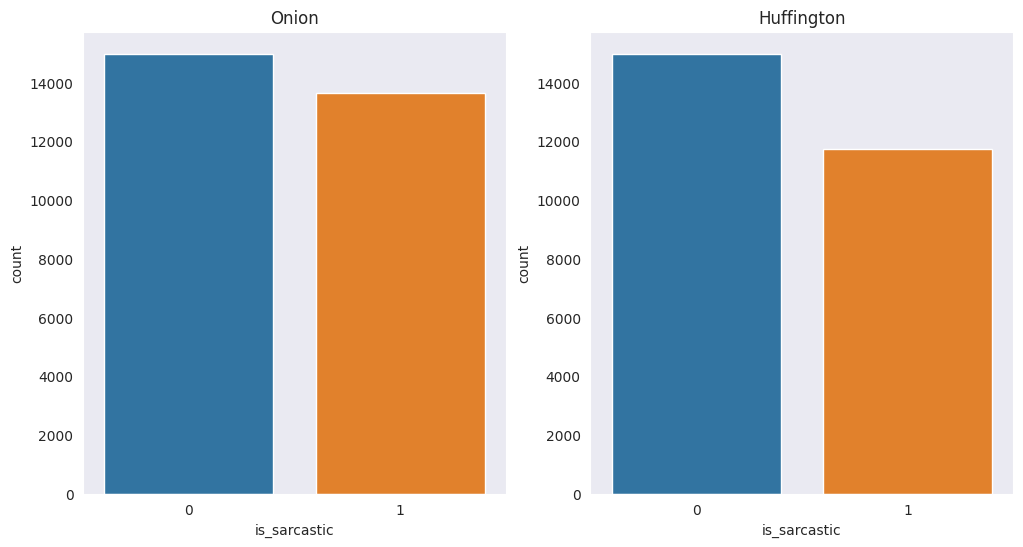

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes = axes.flatten()
sns.countplot(x = onion_df['is_sarcastic'], ax = axes[0])
sns.countplot(x = huff_df['is_sarcastic'], ax = axes[1])
axes[0].set_title('Onion')
axes[1].set_title('Huffington')
plt.show()

In [9]:
stop = set(stopwords.words('english'))
punctuation = set(string.punctuation)
stop.update(punctuation)

In [10]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_https(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_brackets(text)
    text = remove_stopwords(text)
    return text


onion_df['headline'] = onion_df['headline'].apply(denoise_text)
huff_df['headline'] = huff_df['headline'].apply(denoise_text)

<ipython-input-10-d4caf58e8fcc>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


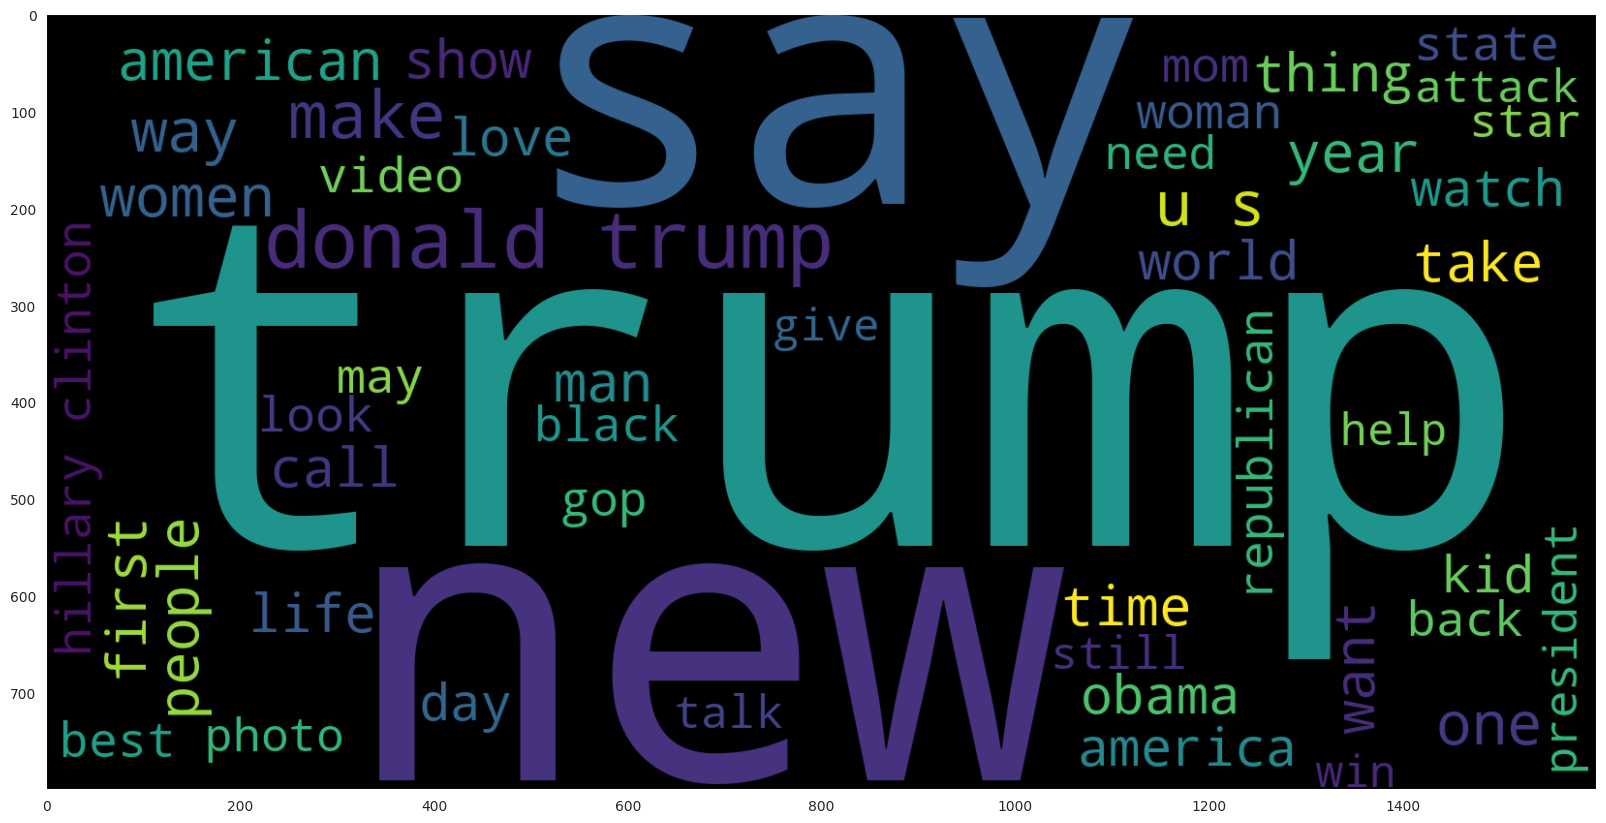

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 50, width = 1600, height = 800 ).generate(" ".join(onion_df[onion_df.is_sarcastic == 0 ].headline))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

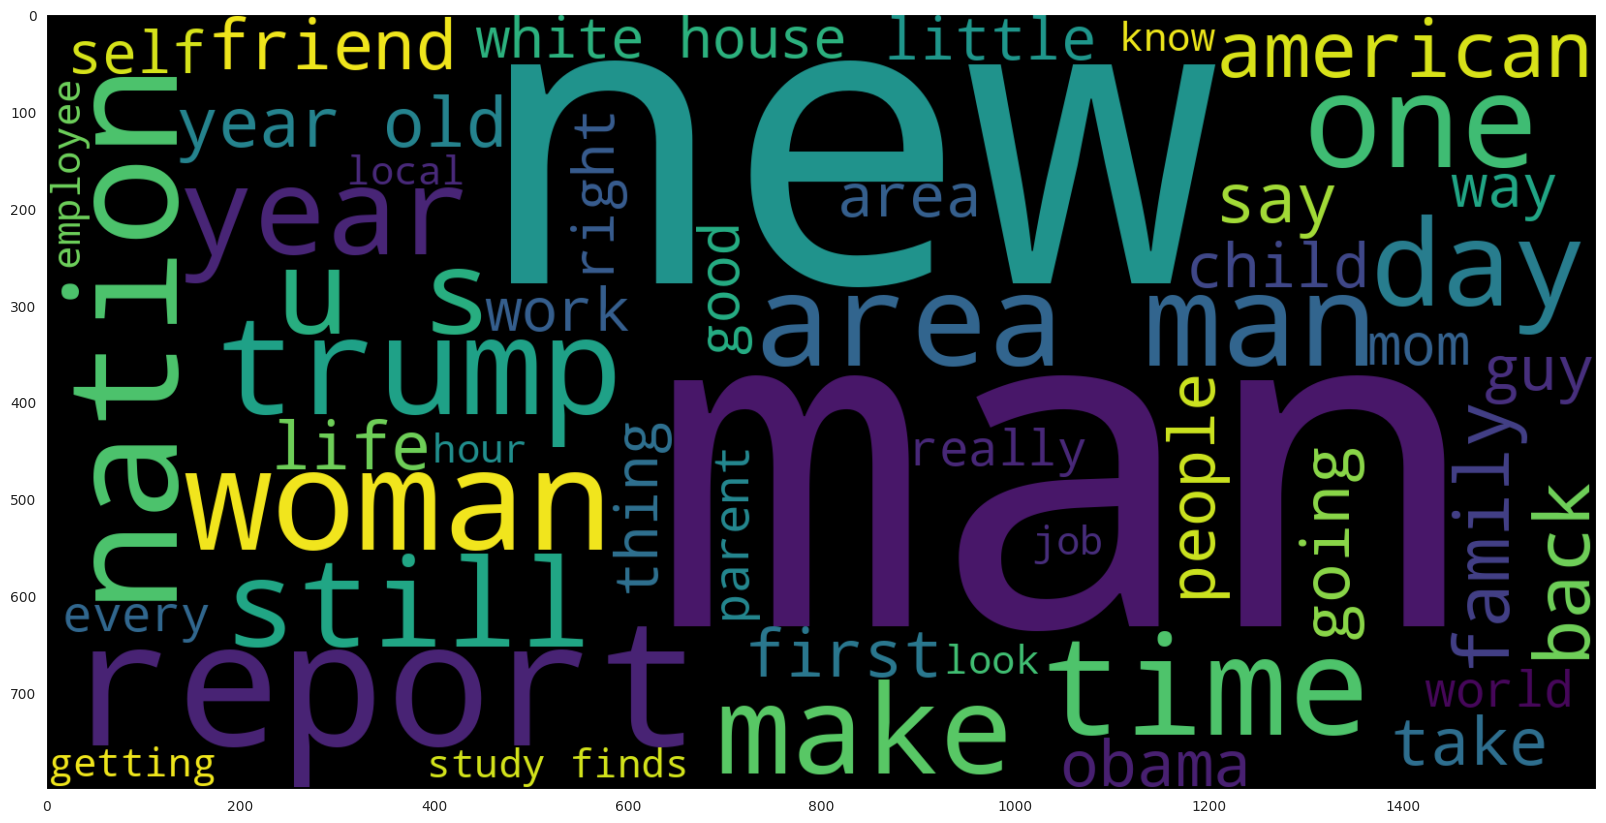

In [12]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 50, width = 1600, height = 800 ).generate(" ".join(onion_df[onion_df.is_sarcastic == 1 ].headline))
plt.imshow(wc, interpolation = 'bilinear')

풍자적이지 않은 경우, 트럼프, 도날드와 같은 이름이 눈에 띈다. 그러나 여기서 얻을 수 있는 인사이트는 특별히 존재하지않다

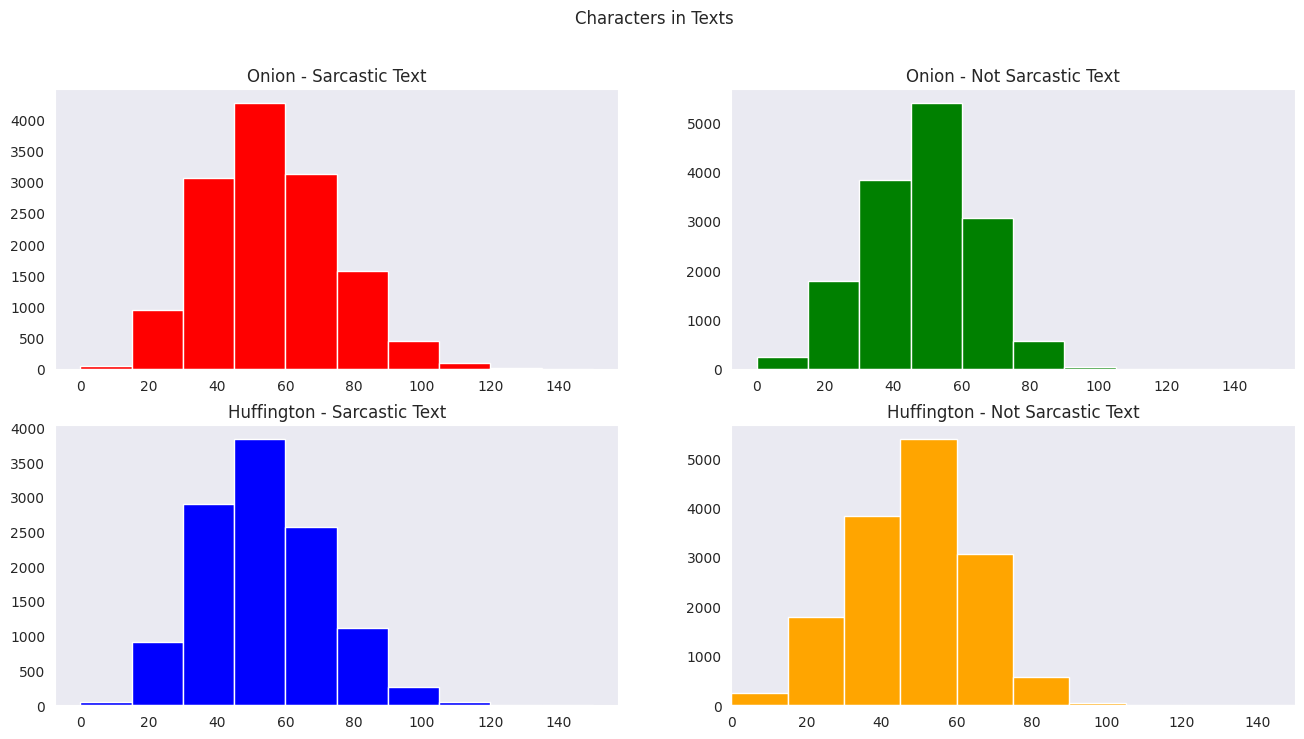

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (16, 8))
axes = axes.flatten()

text_len1 = onion_df[onion_df['is_sarcastic'] == 1 ]['headline'].str.len()
axes[0].hist(text_len1, color = 'red', bins = 10, range = (0, 150))
axes[0].set_title('Onion - Sarcastic Text')

text_len2 = onion_df[onion_df['is_sarcastic'] == 0]['headline'].str.len()
axes[1].hist(text_len2, color = 'green', bins = 10, range = (0, 150))
axes[1].set_title('Onion - Not Sarcastic Text')

text_len3 = huff_df[huff_df['is_sarcastic'] == 1 ]['headline'].str.len()
axes[2].hist(text_len3, color = 'blue', bins = 10, range = (0, 150))
axes[2].set_title('Huffington - Sarcastic Text')

text_len4 = huff_df[huff_df['is_sarcastic'] == 0]['headline'].str.len()
axes[3].hist(text_len4, color = 'orange', bins = 10, range = (0, 150))
axes[3].set_xlim(0, 150)
axes[3].set_title('Huffington - Not Sarcastic Text')
fig.suptitle('Characters in Texts')
plt.show()

<font size = '3'>

풍자적인 헤드라인이 그렇지 않은 것에 비해 최대 글자수가 조금 더 많지만, 유의미한 차이는 보이지 않는다 

In [14]:
df = pd.concat([onion_df, huff_df], axis = 0)

In [15]:
words = []
for i in df['headline'].values:
    words.append(i.split())

w2v_model = gensim.models.Word2Vec(sentences = words, vector_size = 150, 
                                  window = 5, min_count = 5)

num_words = len(w2v_model.wv.key_to_index)

In [16]:
tokenizer = text.Tokenizer(num_words = num_words, oov_token ="<UNK>")
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 50)
vocab_size = len(tokenizer.word_index) + 1

In [34]:

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 150))
    for word, i in vocab.items():
        if word in model.wv: 
            weight_matrix[i] = model.wv[word]
        else:
            weight_matrix[i] = np.zeros(150) 
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


In [35]:
print(type(embedding_vectors))

<class 'numpy.ndarray'>


In [36]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = 150, weights = [embedding_vectors],
                   input_length = 50, trainable = True))

model.add(Bidirectional(LSTM(units = 128, recurrent_dropout = 0.3, dropout = 0.3,
                            return_sequences= True)))
model.add(Bidirectional(GRU(units = 32, recurrent_dropout = 0.1, dropout= 0.1,
                           return_sequences = False)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01), loss = 'binary_crossentropy',
             metrics = ['acc'])

del embedding_vectors

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , 
                                                    test_size = 0.2 , random_state = 0) 
history = model.fit(x_train, y_train, batch_size = 128, validation_data = (x_test, y_test),
                   epochs = 3

print("Accuracy of Training: ", model.evaluate(x_train, y_train)[1] * 100)
print("Accuracy of Testing: ", model.evaluate(x_test, y_test)[1] * 100)

Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 104s 280ms/step - acc: 0.7236 - loss: 0.5562 - val_acc: 0.8923 - val_loss: 0.2677
Epoch 2/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 278ms/step - acc: 0.9377 - loss: 0.1685 - val_acc: 0.9230 - val_loss: 0.2114
Epoch 3/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 279ms/step - acc: 0.9708 - loss: 0.0835 - val_acc: 0.9388 - val_loss: 0.1975
Epoch 4/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 277ms/step - acc: 0.9831 - loss: 0.0501 - val_acc: 0.9429 - val_loss: 0.2079
Epoch 5/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 96s 279ms/step - acc: 0.9879 - loss: 0.0376 - val_acc: 0.9440 - val_loss: 0.2187
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 71s 51ms/step - acc: 0.9928 - loss: 0.0232
Accuracy of Training:  99.26347732543945
346/346 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - acc: 0.9453 - loss: 0.2079
Accuracy of Testing:  94.39725279808044


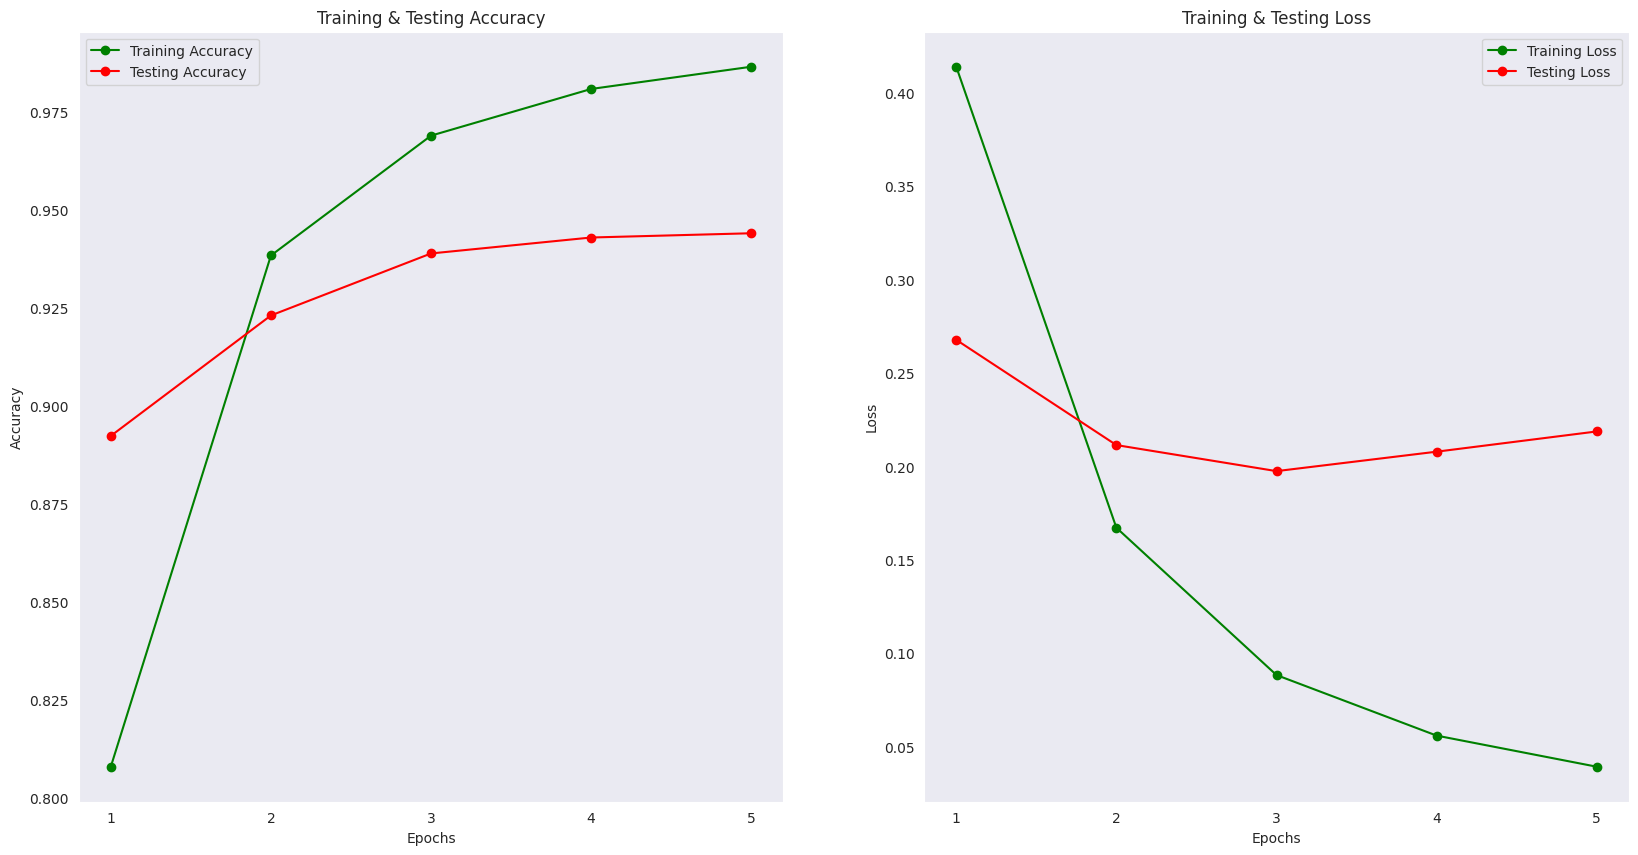

In [40]:
epochs = [i for i in range(1, 4)]
fig, axes = plt.subplots(1, 2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)


axes[0].plot(epochs ,train_acc, 'go-', label = 'Training Accuracy')
axes[0].plot(epochs, val_acc, 'ro-', label = 'Testing Accuracy')
axes[0].set_title('Training & Testing Accuracy')
axes[0].legend()
axes[0].set_xticks(epochs)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')



axes[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
axes[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
axes[1].set_title('Training & Testing Loss')
axes[1].legend()
axes[1].set_xticks(epochs)
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
plt.show()

346/346 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step


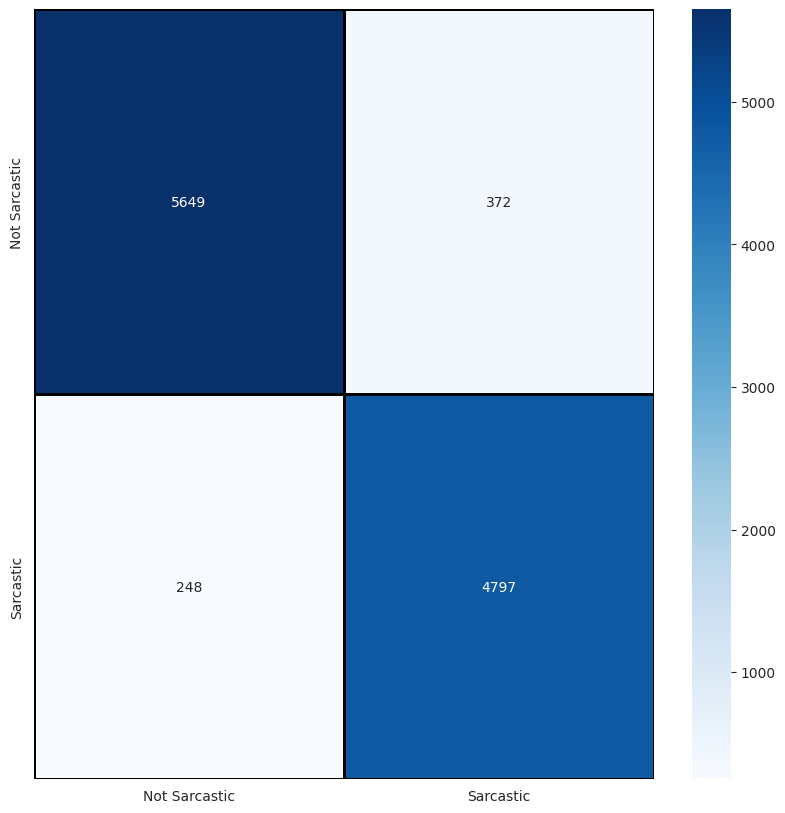

In [41]:
y_pred = (model.predict(x_test) > 0.5 ).astype("int32")

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = ['Not Sarcastic', 'Sarcastic'],
                     columns = ['Not Sarcastic', 'Sarcastic'])
plt.figure(figsize = (10, 10 ))
sns.heatmap(cm_df, cmap = 'Blues', linecolor ='black', linewidth = 1, annot = True, 
            cbar = True, fmt = 'd', xticklabels = ['Not Sarcastic', 'Sarcastic'],
           yticklabels = ['Not Sarcastic', 'Sarcastic'])
plt.show()


### 이번엔 Word2Vec이 아닌, 좀 더 업그레이드된 버전인 GloVe를 사용해보자.

In [44]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2025-02-10 06:17:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-10 06:17:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-10 06:17:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [61]:
words = [i.split() for i in df['headline'].values ]

tokenizer = text.Tokenizer(oov_token = "<UNK>")
tokenizer.fit_on_texts(words)

tokenized_train = tokenizer.texts_to_sequences(words)

vocab_size = len(tokenizer.word_index) + 1


glove_path = "glove.6B.100d.txt"
embedding_dim = 100 

In [62]:

def load_glove_embeddings(glove_path, tokenizer, embedding_dim):
    embedding_index = {}

    with open(glove_path, encoding = 'utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype = "float32")
            embedding_index[word] = vector
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_vectors = load_glove_embeddings(glove_path, tokenizer, embedding_dim)

In [63]:

model = Sequential()
model.add(Embedding(vocab_size, output_dim = embedding_dim, weights = [embedding_vectors],
                   input_length = 50, trainable = True))
model.add(Bidirectional(LSTM(units = 128, recurrent_dropout= 0.3, dropout = 0.3,
                       return_sequences = True)))
model.add(Bidirectional(GRU(units =32, recurrent_dropout = 0.1, dropout= 0.1, 
                           return_sequences = False)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
             loss = 'binary_crossentropy',
             metrics =['acc'])

del embedding_vectors


In [64]:

x = sequence.pad_sequences(tokenized_train, maxlen = 50)
X_train, X_test, y_train, y_test = train_test_split(x, df.is_sarcastic, test_size=0.2, random_state=0)

history = model.fit(X_train, y_train, batch_size = 128, validation_data = (x_test, y_test), epochs = 3)


print("Accuracy of Training: ", model.evaluate(x_train, y_train)[1] * 100)
print("Accuracy of Testing: ", model.evaluate(x_test, y_test)[1] * 100)

Epoch 1/3
346/346 ━━━━━━━━━━━━━━━━━━━━ 101s 274ms/step - acc: 0.7753 - loss: 0.4514 - val_acc: 0.8835 - val_loss: 0.2801
Epoch 2/3
346/346 ━━━━━━━━━━━━━━━━━━━━ 94s 272ms/step - acc: 0.9746 - loss: 0.0770 - val_acc: 0.9039 - val_loss: 0.2621
Epoch 3/3
346/346 ━━━━━━━━━━━━━━━━━━━━ 94s 273ms/step - acc: 0.9935 - loss: 0.0198 - val_acc: 0.8972 - val_loss: 0.3798
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 69s 50ms/step - acc: 0.9259 - loss: 0.2520
Accuracy of Training:  92.61443018913269
346/346 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - acc: 0.8993 - loss: 0.3676
Accuracy of Testing:  89.71624970436096


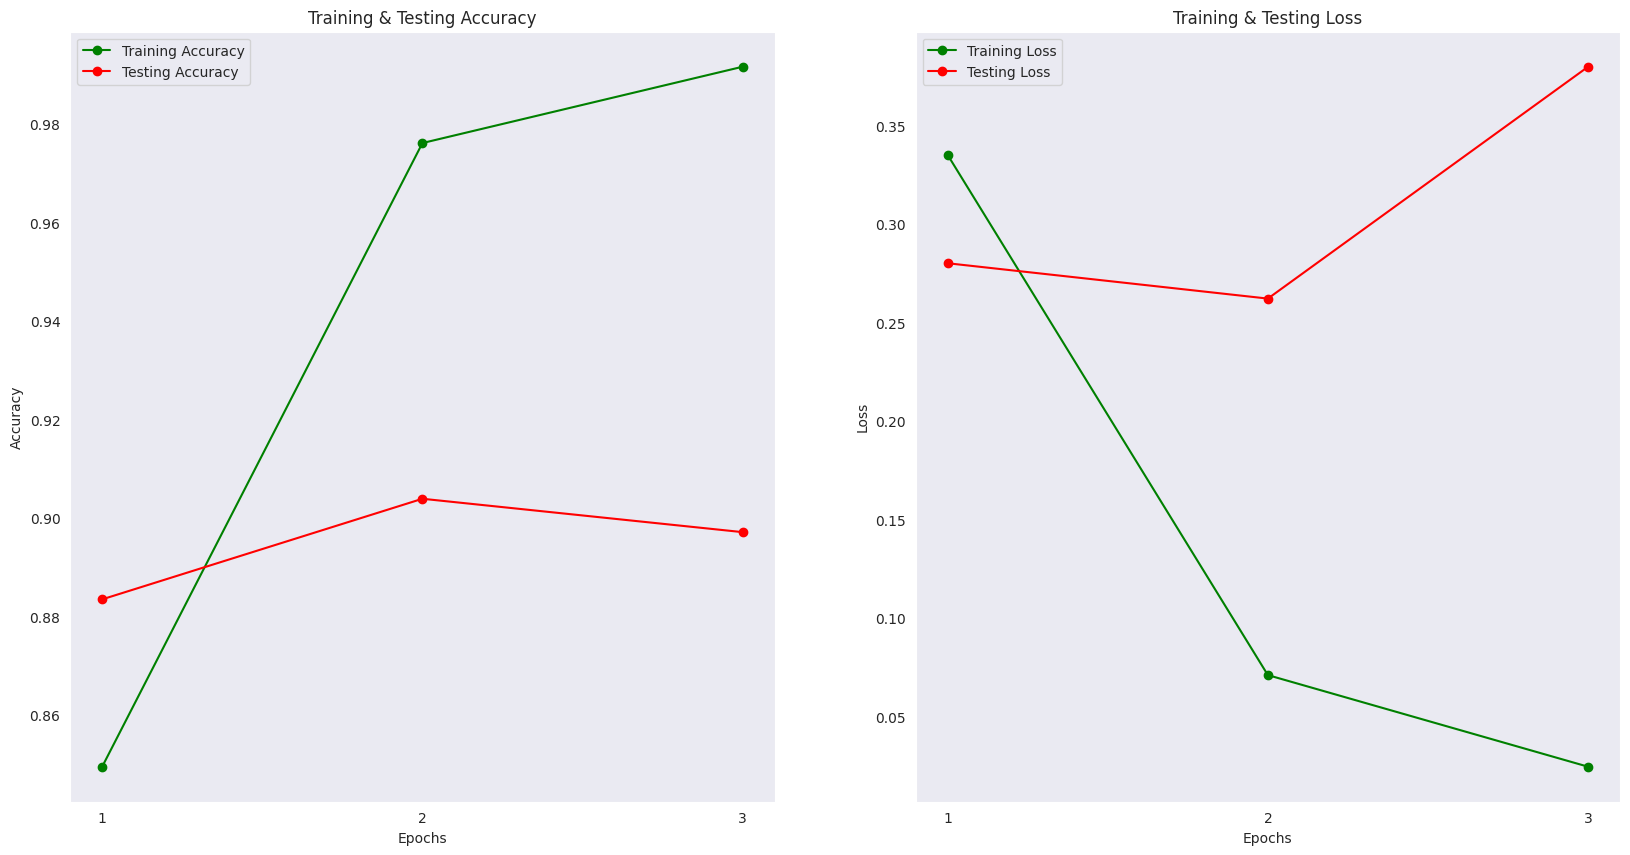

In [66]:
epochs = [i for i in range(1,4)]
fig, axes = plt.subplots(1, 2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)


axes[0].plot(epochs ,train_acc, 'go-', label = 'Training Accuracy')
axes[0].plot(epochs, val_acc, 'ro-', label = 'Testing Accuracy')
axes[0].set_title('Training & Testing Accuracy')
axes[0].legend()
axes[0].set_xticks(epochs)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')



axes[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
axes[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
axes[1].set_title('Training & Testing Loss')
axes[1].legend()
axes[1].set_xticks(epochs)
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
plt.show()

이 경우에 한해선 Word2Vec의 성능이 Testing Accuracy 기준 약 3% 가량 더 좋았다 (dim = 100, 200 둘 다 사용)